# Mask R-CNN

Applying a mask that will outline car damage.

Mask_RCNN GitHub: https://github.com/matterport/Mask_RCNN

Download Coco at: https://github.com/matterport/Mask_RCNN/releases

This code will work on this docker container: https://hub.docker.com/r/waleedka/modern-deep-learning/

NOTE: the logs folder and mask_rcnn_coco.h5 files were not added to GitHub because they are too big. If you want to run this code, you must download coco and run the training in the cell below "Model Setup". 

#### IMPORTANT:
To train this model, I had to make the updates to model.py detailed here:
https://github.com/keras-team/keras/issues/10311

In [96]:
import json
import math
import numpy as np
import os
import random
import tensorflow as tf

import matplotlib.pyplot as plt

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import custom

In [6]:
# Load dataset
DATA_DIR = os.getcwd() + "/data/"
dataset = custom.CustomDataset()
dataset.load_custom(DATA_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 641
Class Count: 2
  0. BG                                                
  1. damage                                            


### Visualize some car damage images and associated masks
The second column are the masks we annotated for the cars shown on the left. If there is more than one area with damage, then the other annotations would show up in theplots to the left. 

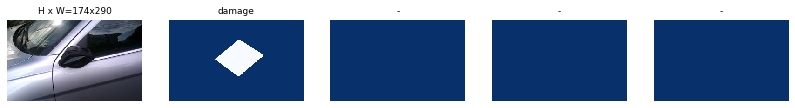

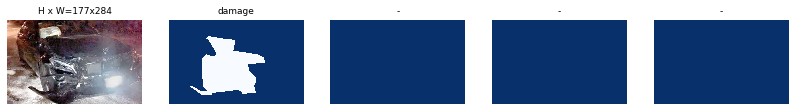

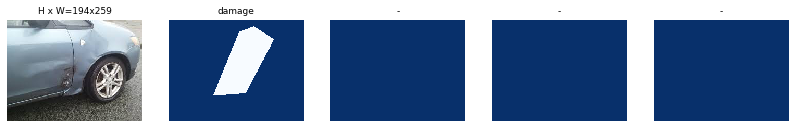

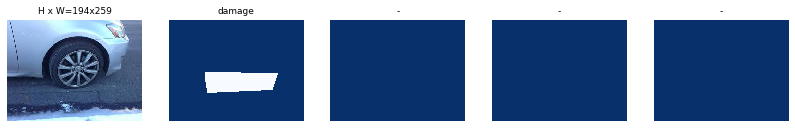

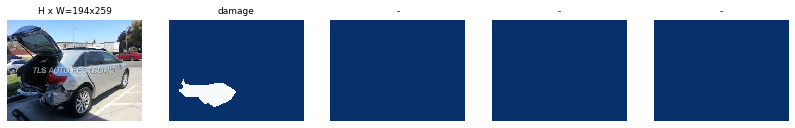

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Check the Bounding Box with annotated damage mask for a typical car image

Here is an example image with our annotation and bounding box around it. 

image_id  424 //Users/patriciadegner/Desktop/car_damage_upload/unsupervised_learning/data/train/0648.JPEG
image                    shape: (156, 322, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (156, 322, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    8.00000  max:  142.00000  int32


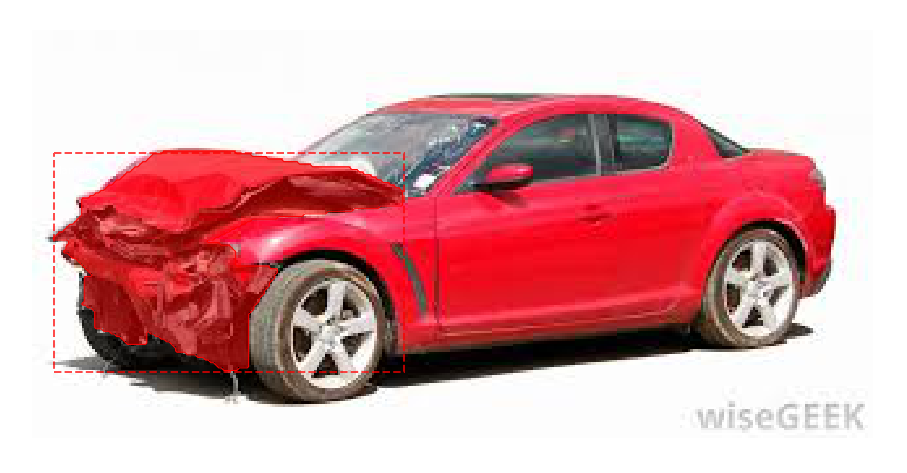

In [16]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [22]:
#Annotation file load
annotations = list(json.load(open(os.path.join(DATA_DIR + "/train/via_region_data.json"),encoding="utf8")).values())
annotations = [a for a in annotations if a['regions']]
annotations[0]

{'fileref': '',
 'size': 9234,
 'filename': '0001.JPEG',
 'base64_img_data': '',
 'file_attributes': {},
 'regions': {'0': {'shape_attributes': {'name': 'polygon',
    'all_points_x': [4, 50, 136, 296, 293, 4],
    'all_points_y': [50, 117, 130, 110, 23, 50]},
   'region_attributes': {}}}}

# Model Setup


### Train the model

In [55]:
## this will generate 50 .h5 files. We will use them to load weights below. 
# !python custom.py train --dataset=/Users/patriciadegner/Desktop/car_damage_upload/unsupervised_learning/data/ --weights=coco

In [109]:
config = custom.CustomConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

### Load model weights

In [110]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

from importlib import reload # was constantly changing the visualization, so I decided to reload it instead of notebook
reload(visualize)

# Create model in inference mode
MODEL_DIR = "/Users/patriciadegner/Desktop/car_damage_upload/unsupervised_learning/logs/damage20201021T1457"
custom_WEIGHTS_PATH = MODEL_DIR + "/mask_rcnn_damage_0050.h5"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# load the last best model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
load_weights(model, custom_WEIGHTS_PATH, by_name=True)   

Loading weights  /Users/patriciadegner/Desktop/car_damage_upload/unsupervised_learning/logs/damage20201021T1457/mask_rcnn_damage_0050.h5
Re-starting from epoch 50


In [56]:
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_6/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1_6/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1_6/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1_6/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1_6/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1_6/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a_6/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a_6/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a_6/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a_6/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


### Predict on All Validation Images

Then view a random example

In [112]:
import glob
import skimage.draw

results=[]
val_dir = DATA_DIR + 'val/'
filelist = glob.glob(os.path.join(val_dir, '*.JPEG')) 
filelist.sort()

for i, image_path in enumerate(filelist):
    image = skimage.io.imread(image_path)
    
    # Run object detection
    result = model.detect([image])
    results.append(result)

pos_preds = 0
for i in range(len(results)):
    print((filelist[i][-9:]), ": Class = ",results[i][0].get("class_ids", 0), "  ", "Score = ",results[i][0].get("scores", 0))
    if len(results[i][0].get("class_ids", 0)) >0: pos_preds+=1
        
print ("number of images validated =", len(results))        
print ("accuracy =", pos_preds/len(results))

0112.JPEG : Class =  [1]    Score =  [0.99672866]
0285.JPEG : Class =  [1]    Score =  [0.97528404]
0465.JPEG : Class =  [1 1]    Score =  [0.9758958 0.904428 ]
0498.JPEG : Class =  [1]    Score =  [0.99841285]
0504.JPEG : Class =  [1]    Score =  [0.9960341]
0519.JPEG : Class =  [1]    Score =  [0.9946386]
0529.JPEG : Class =  [1 1]    Score =  [0.99283266 0.92113656]
0539.JPEG : Class =  [1]    Score =  [0.99484915]
0554.JPEG : Class =  [1]    Score =  [0.9985341]
0555.JPEG : Class =  [1 1]    Score =  [0.9825616  0.90818685]
0563.JPEG : Class =  [1]    Score =  [0.974019]
0582.JPEG : Class =  [1]    Score =  [0.9737241]
0584.JPEG : Class =  [1 1]    Score =  [0.9896569 0.9861957]
0588.JPEG : Class =  []    Score =  []
0593.JPEG : Class =  [1]    Score =  [0.97523266]
0606.JPEG : Class =  [1]    Score =  [0.99330324]
0616.JPEG : Class =  [1]    Score =  [0.9951255]
0627.JPEG : Class =  [1]    Score =  [0.9942545]
0642.JPEG : Class =  [1 1]    Score =  [0.98964393 0.9425135 ]
0644.JPE

0878.JPEG : Class =  [1]    Score =  [0.99169546]
0879.JPEG : Class =  [1]    Score =  [0.9719179]
0880.JPEG : Class =  [1]    Score =  [0.95934534]
0881.JPEG : Class =  [1]    Score =  [0.9611954]
0882.JPEG : Class =  [1]    Score =  [0.99665785]
0883.JPEG : Class =  [1]    Score =  [0.9808148]
0884.JPEG : Class =  [1]    Score =  [0.9847521]
0885.JPEG : Class =  [1 1]    Score =  [0.9796607 0.9574944]
0886.JPEG : Class =  [1]    Score =  [0.9742643]
0887.JPEG : Class =  [1]    Score =  [0.9949207]
0888.JPEG : Class =  [1]    Score =  [0.95954585]
0889.JPEG : Class =  []    Score =  []
0890.JPEG : Class =  [1]    Score =  [0.9408604]
0892.JPEG : Class =  [1]    Score =  [0.9946181]
0893.JPEG : Class =  [1]    Score =  [0.98805946]
0894.JPEG : Class =  [1]    Score =  [0.96970636]
0895.JPEG : Class =  []    Score =  []
0896.JPEG : Class =  []    Score =  []
0897.JPEG : Class =  [1]    Score =  [0.9931098]
0898.JPEG : Class =  []    Score =  []
0899.JPEG : Class =  []    Score =  []
090

Processing 1 images
image                    shape: (225, 225, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


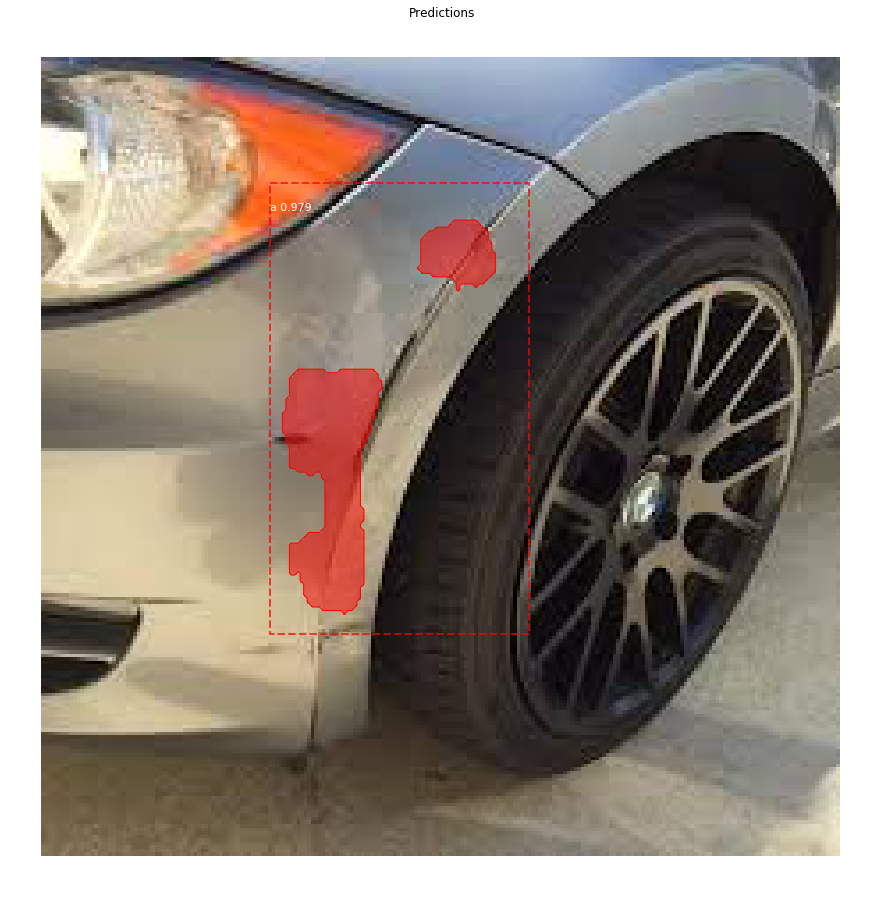

In [129]:
test_dir = DATA_DIR + 'test/'
filelist = glob.glob(os.path.join(test_dir, '*.JPEG'))

image_id = random.choice(filelist)
image = skimage.io.imread(image_id)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            'damage', r['scores'], ax=ax,
                            title="Predictions")